# Data Science Final Project

## Alexander Ho, Garrett Nelson

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib as plt

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler  
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [2]:
#https://fred.stlouisfed.org/series/FEDFUNDS
data1 = pd.read_csv('federal-funds-rate.csv')
df1 = pd.DataFrame(data1)
df1.head()

,DATE,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83


In [3]:
print(df1.shape)

(821, 2)


In [4]:
#https://fred.stlouisfed.org/series/BOGZ1FL072052006Q
data2 = pd.read_csv('interest-rates.csv')
df2 = pd.DataFrame(data2)
df2.head()

,DATE,BOGZ1FL072052006Q
0,1954-07-01,1.07
1,1954-10-01,1.28
2,1955-01-01,1.35
3,1955-04-01,1.64
4,1955-07-01,2.18


In [5]:
print(df2.shape)

(272, 2)


In [6]:
#https://fred.stlouisfed.org/series/A191RL1Q225SBEA
data3 = pd.read_csv('real-gross-domestic-product.csv')
df3 = pd.DataFrame(data3)
df3.head()

,DATE,A191RL1Q225SBEA
0,1947-04-01,-1.1
1,1947-07-01,-0.8
2,1947-10-01,6.4
3,1948-01-01,6.2
4,1948-04-01,6.8


In [7]:
print(df3.shape)

(302, 2)


In [8]:
#https://fred.stlouisfed.org/series/UNRATE
data4 = pd.read_csv('unemployment-rate.csv')
df4 = pd.DataFrame(data4)
df4.head()

,DATE,UNRATE
0,1948-01-01,3.4
1,1948-02-01,3.8
2,1948-03-01,4.0
3,1948-04-01,3.9
4,1948-05-01,3.5


In [9]:
print(df4.shape)

(898, 2)


In [10]:
df1['DATE'] = pd.to_datetime(df1['DATE'])
df2['DATE'] = pd.to_datetime(df2['DATE'])
df3['DATE'] = pd.to_datetime(df3['DATE'])
df4['DATE'] = pd.to_datetime(df4['DATE'])

# Format Dates

In [11]:
# remove any points earlier than june 30th, 1954
# july is start of Q3 so remove data points earlier than july 1954

def remove_date(d1, d2, d3, d4):
    # data is input with data-time already implemented
    # print(data['DATE'].dt.date)
    c1 = d1[~(d1['DATE'] < '1954-07-01')]
    c2 = d2[~(d2['DATE'] < '1954-07-01')]
    c3 = d3[~(d3['DATE'] < '1954-07-01')]
    c4 = d4[~(d4['DATE'] < '1954-07-01')]

    return c1, c2, c3, c4


df1, df2, df3, df4 = remove_date(df1, df2, df3, df4)

#check
# df4['DATE'].head()


In [12]:
df2

,DATE,BOGZ1FL072052006Q
0,1954-07-01,1.07
1,1954-10-01,1.28
2,1955-01-01,1.35
3,1955-04-01,1.64
4,1955-07-01,2.18
...,...,...
267,2021-04-01,0.08
268,2021-07-01,0.08
269,2021-10-01,0.08
270,2022-01-01,0.20


# Add Recession

In [13]:
merge_df = pd.merge(df1, df2, how="left", on=["DATE"])
merge_df = pd.merge(merge_df, df3, how="left", on=["DATE"])
merge_df = pd.merge(merge_df, df4, how="left", on=["DATE"])

In [14]:
merge_df.head()

,DATE,FEDFUNDS,BOGZ1FL072052006Q,A191RL1Q225SBEA,UNRATE
0,1954-07-01,0.80,1.07,4.6,5.8
1,1954-08-01,1.22,NaN,NaN,6.0
2,1954-09-01,1.07,NaN,NaN,6.1
3,1954-10-01,0.85,1.28,8.1,5.7
4,1954-11-01,0.83,NaN,NaN,5.3


# Quarterly Formatting

In [15]:
temp_df1 = df1.groupby(df1['DATE'].dt.to_period('Q'))['FEDFUNDS'].sum()

In [16]:
# renaming data in columns
merge_df.rename(columns = {'DATE':'date', 'FEDFUNDS':'fed-rate', 'UNRATE':'une-rate', 'A191RL1Q225SBEA':'r-gdp', 'BOGZ1FL072052006Q':'int-rate'}, inplace = True)
merge_df.head()

,date,fed-rate,int-rate,r-gdp,une-rate
0,1954-07-01,0.80,1.07,4.6,5.8
1,1954-08-01,1.22,NaN,NaN,6.0
2,1954-09-01,1.07,NaN,NaN,6.1
3,1954-10-01,0.85,1.28,8.1,5.7
4,1954-11-01,0.83,NaN,NaN,5.3


In [17]:
# grouping by quarter while averaging the data inside
gdp = merge_df.groupby(merge_df['date'].dt.to_period('Q'))['r-gdp'].sum().round(1)
inr = merge_df.groupby(merge_df['date'].dt.to_period('Q'))['int-rate'].sum().round(1)
fer = merge_df.groupby(merge_df['date'].dt.to_period('Q'))['fed-rate'].mean().round(1)
une = merge_df.groupby(merge_df['date'].dt.to_period('Q'))['une-rate'].mean().round(1)
dte = merge_df.groupby(merge_df['date'].dt.to_period('Q'))['date']

data = fer.to_frame()
data = pd.merge(data, inr.to_frame(), how = 'left', on = ['date'])
data = pd.merge(data, une.to_frame(), how = 'left', on = ['date'])
data = pd.merge(data, gdp.to_frame(), how = 'left', on = ['date'])

data.reset_index(drop = False, inplace = True)
data['date'] = data['date'].astype(str)
data['date'] = pd.to_datetime(data['date'])
# data['date'] = pd.to_datetime(data['date']).dt.to_period('Q')
# print(data['date'].dt.year)
# print(data['date'].dt.quarter)
data.head()

,date,fed-rate,int-rate,une-rate,r-gdp
0,1954-07-01,1.0,1.1,6.0,4.6
1,1954-10-01,1.0,1.3,5.3,8.1
2,1955-01-01,1.3,1.4,4.7,11.9
3,1955-04-01,1.5,1.6,4.4,6.6
4,1955-07-01,1.9,2.2,4.1,5.5


In [18]:
# adding back in recession years
rec_Qs = []
# rec_1954 = pd.date_range(start='7/01/1953', end='6/30/1954', freq='QS')
# rec_1954 = pd.date_range(start = '07/01/1953', end = '6/30/1954', periods = 4)

# rec_Qs.append(rec_1954)

rec_1957 = pd.date_range(start='1957Q3', end='1958Q2',freq='QS')
rec_Qs.append(rec_1957)

rec_1960 = pd.date_range(start='1960Q2', end='1961Q1',freq='QS')
rec_Qs.append(rec_1960)

rec_1969 = pd.date_range(start='1969Q4', end='1970Q4',freq='QS')
rec_Qs.append(rec_1969)

rec_1973 = pd.date_range(start='1973Q4', end='1975Q1',freq='QS')
rec_Qs.append(rec_1973)

rec_1980 = pd.date_range(start='1980Q1', end='1980Q2',freq='QS')
rec_Qs.append(rec_1980)

rec_1981 = pd.date_range(start='1981Q3', end='1982Q4',freq='QS')
rec_Qs.append(rec_1981)

rec_1990 = pd.date_range(start='1990Q3', end='1991Q1',freq='QS')
rec_Qs.append(rec_1990)

rec_2001 = pd.date_range(start='2001Q1', end='2001Q4',freq='QS')
rec_Qs.append(rec_2001)

rec_2008 = pd.date_range(start='2007Q4', end='2009Q2',freq='QS')
rec_Qs.append(rec_2008)

In [19]:
rec_val = []
for i in rec_Qs:
    for j in i:
        temp = pd.Timestamp(j)
        temp.replace(day=1)
        rec_val.append(temp)
   
rec_val = pd.DataFrame(rec_val, columns = ['date'])   
rec_val['Recession'] = rec_val['Recession'].values[:] = 1
rec_val.head()

data = pd.merge(data, rec_val, how = 'left', on = ['date'])
data.rename(columns = {'Recession':'rec'}, inplace = True)
data['rec'] = data['rec'].fillna(0)
# data['n-rec'] = ~pd.Series(data['rec'])
data.head(10)

,date,fed-rate,int-rate,une-rate,r-gdp,rec
0,1954-07-01,1.0,1.1,6.0,4.6,0.0
1,1954-10-01,1.0,1.3,5.3,8.1,0.0
2,1955-01-01,1.3,1.4,4.7,11.9,0.0
3,1955-04-01,1.5,1.6,4.4,6.6,0.0
4,1955-07-01,1.9,2.2,4.1,5.5,0.0
5,1955-10-01,2.4,2.5,4.2,2.4,0.0
6,1956-01-01,2.5,2.5,4.0,-1.5,0.0
7,1956-04-01,2.7,2.7,4.2,3.3,0.0
8,1956-07-01,2.8,3.0,4.1,-0.4,0.0
9,1956-10-01,2.9,2.9,4.1,6.8,0.0


# Preliminary Data Analysis

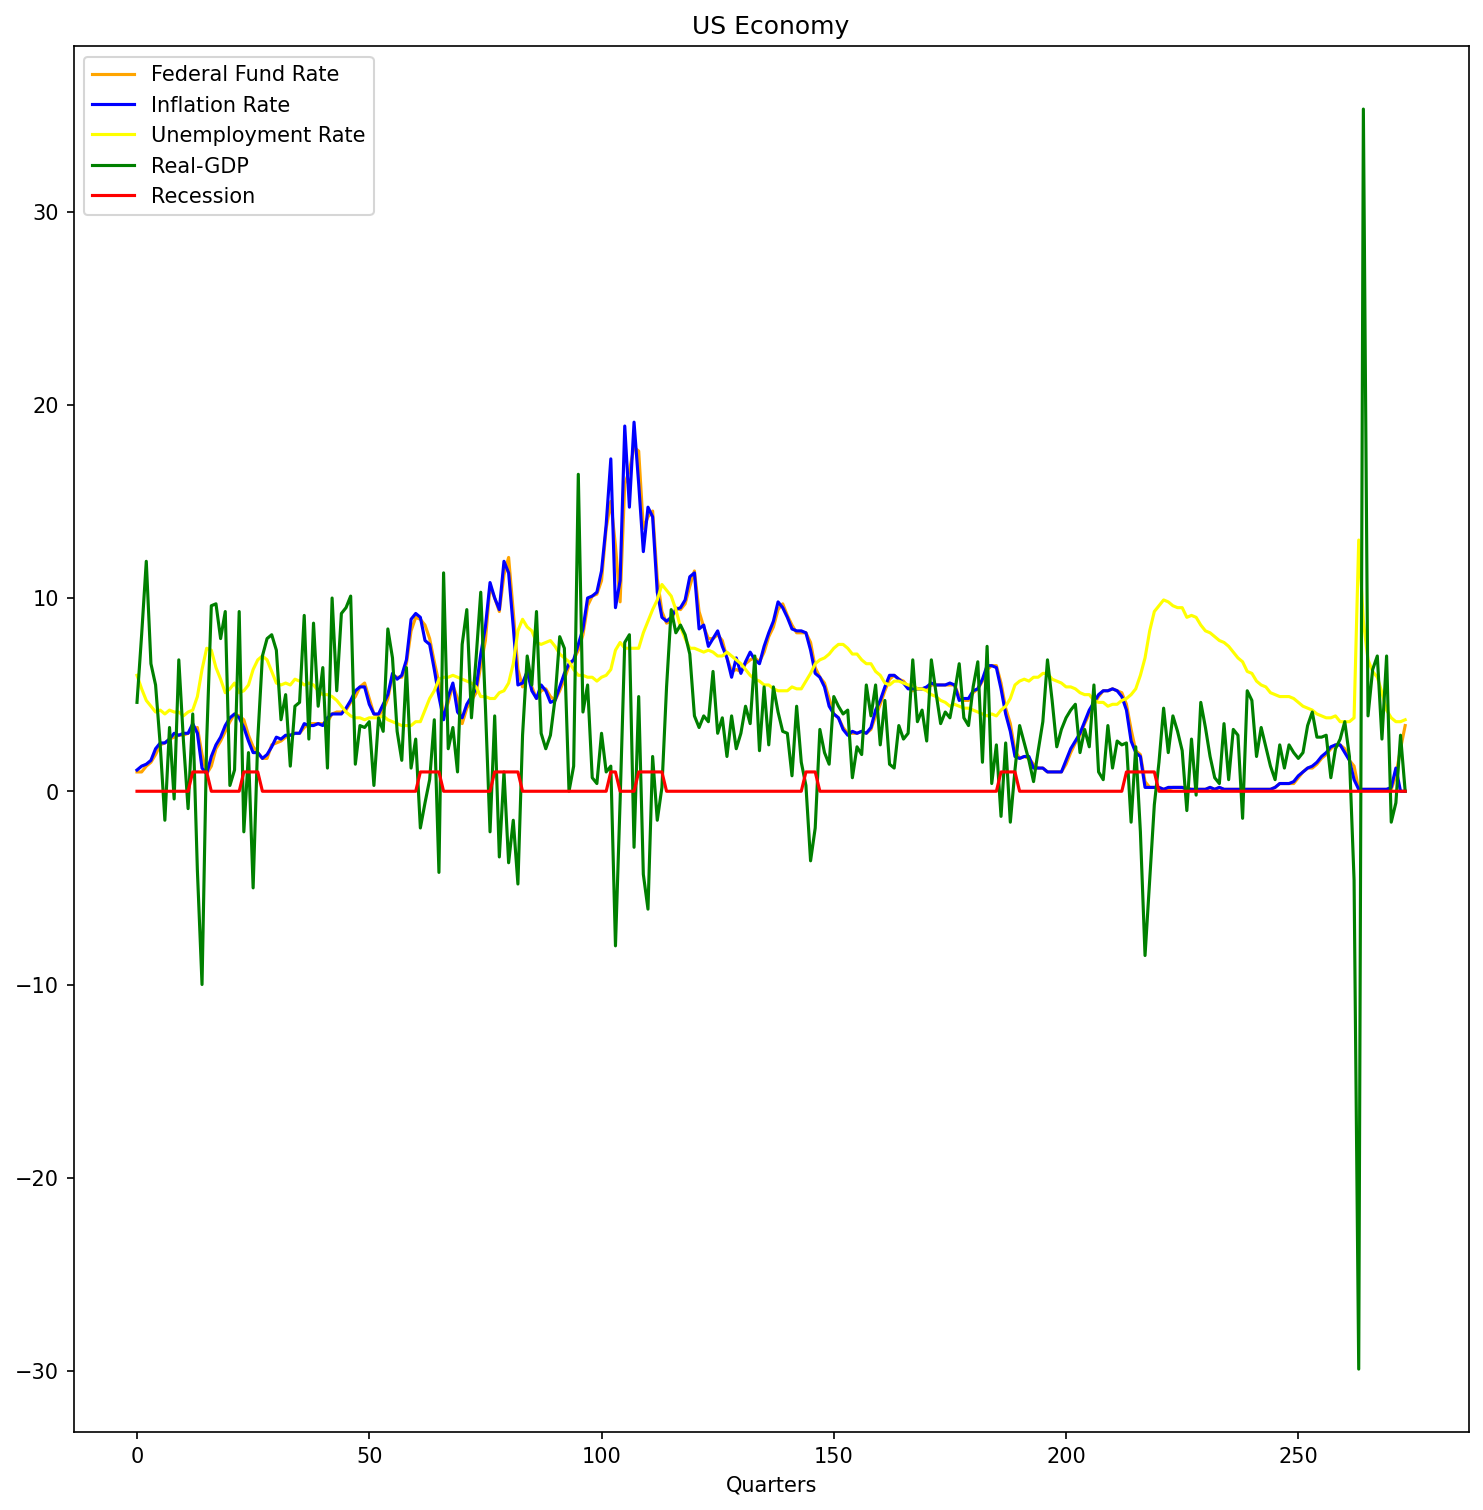

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 12), dpi=150)
  
# using plot method to plot open prices.
# in plot method we set the label and color of the curve.
data['fed-rate'].plot(label='Federal Fund Rate', color='orange')
data['int-rate'].plot(label='Inflation Rate', color='blue')
data['une-rate'].plot(label='Unemployment Rate', color='yellow')
data['r-gdp'].plot(label='Real-GDP', color='green')
data['rec'].plot( label='Recession', color='red')
  
# adding title to the plot
plt.title('US Economy')
  
# adding Label to the x-axis
plt.xlabel('Quarters')
#plt.set_index(data['date'])
# adding legend to the curve
plt.legend()

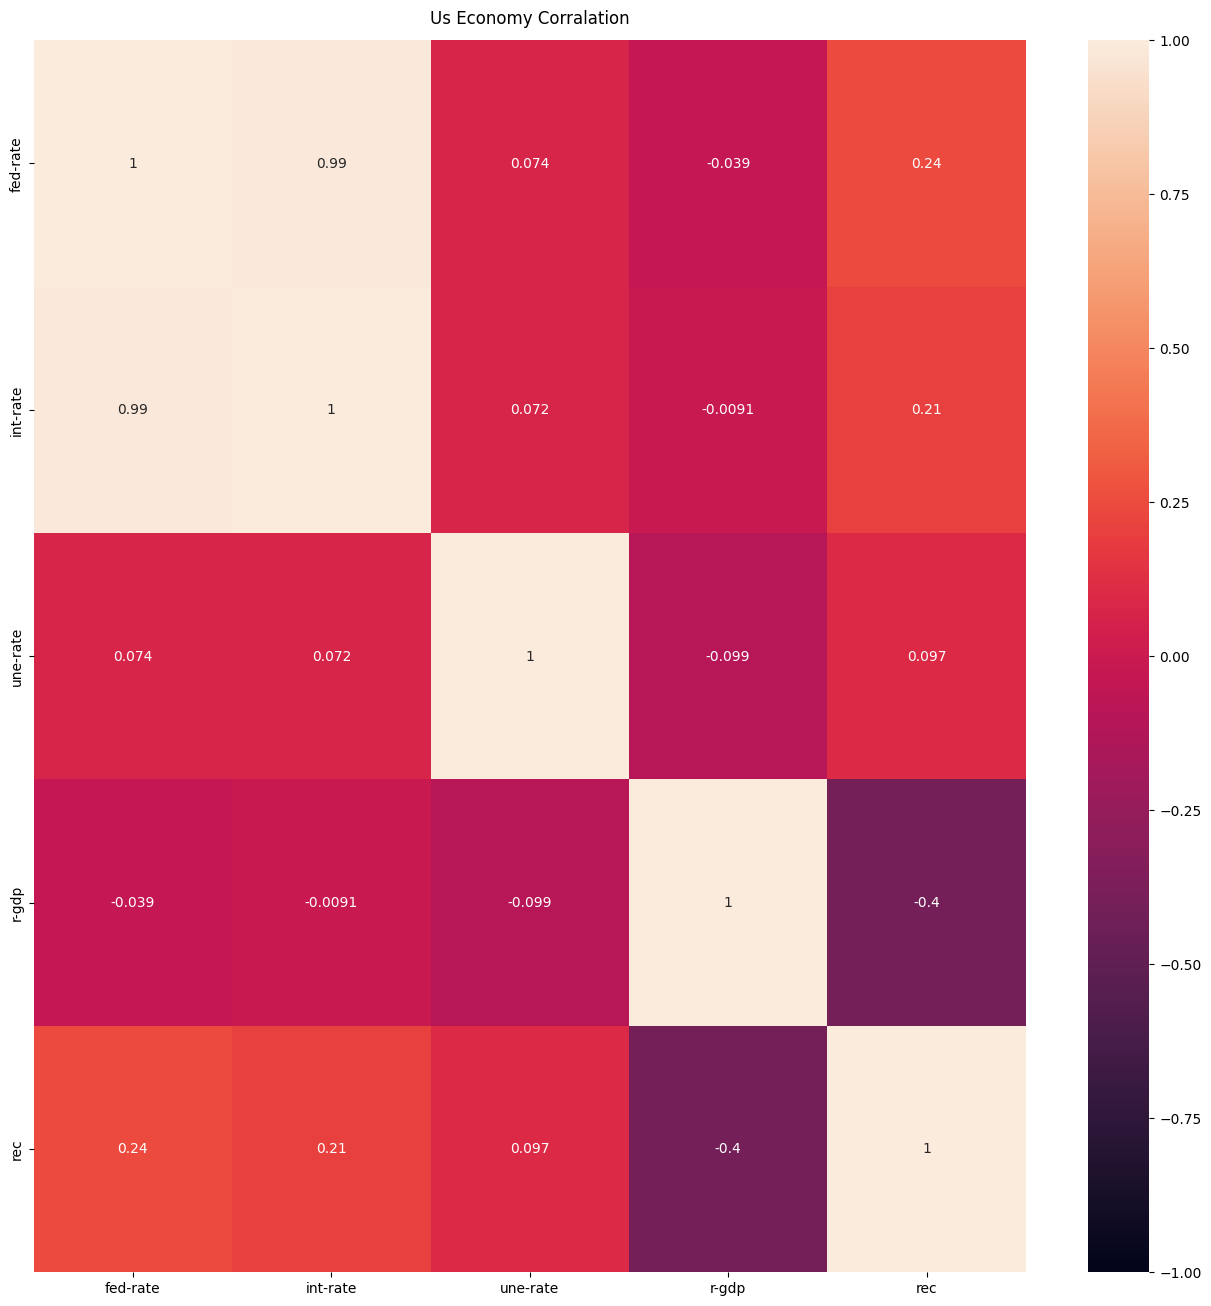

In [21]:
plt.figure(figsize=(16, 16))
heatmap = sn.heatmap(data.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Us Economy Corralation', fontdict={'fontsize':12}, pad=12);

In [22]:
# data is fully setup: looking to identify trends and predict values
# identifying trends through visualization

# what are overall trends per in recession quarters and non recession quarters
data.groupby(['rec']).mean().round(1)
# averaging these results, we can see that we see an average of increased rates for fed/int rates as well as increase in unemployment. yet real-gdp historically averages down

,fed-rate,int-rate,une-rate,r-gdp
rec,,,,
0.0,4.2,4.3,5.8,3.9
1.0,6.7,6.4,6.3,-1.2


In [23]:
 # total sum of measures taken during recessions
 data.groupby(['rec']).sum().round(1)
 # we can see that loosening measures take place during recessions, for rates even with unemployment but real-gdp drops due to economic decreases over consecutive quarters

,fed-rate,int-rate,une-rate,r-gdp
rec,,,,
0.0,984.8,994.6,1354.3,897.3
1.0,274.4,260.9,256.7,-49.7


In [24]:
# test plot
# sns.set(font_scale = 1)

# sns.lmplot(data = data, x = )

In [25]:
print(data['rec'].value_counts())

0.0    233
1.0     41
Name: rec, dtype: int64


<AxesSubplot: >

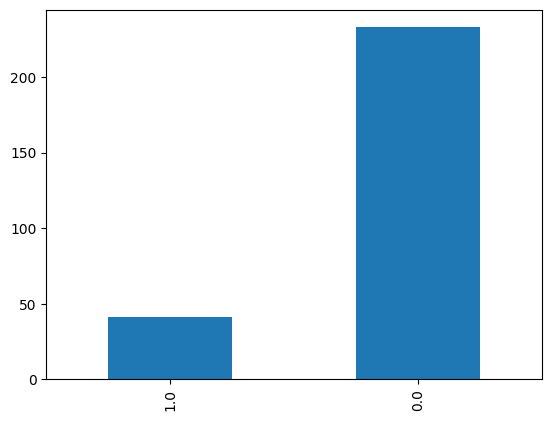

In [26]:
# to highlight the imbalance of data
data.rec.value_counts().sort_values().plot(kind = 'bar')

In [27]:
temp_df2 = data.groupby(['rec']).mean()
#data.groupby(['rec']).rec.mean().to_frame().loc[lambda x: x['rec']>0]
print(temp_df2)
# temp_df2  
#data['rec'].mean()

     fed-rate  int-rate  une-rate     r-gdp
rec                                        
0.0  4.226609  4.268670  5.812446  3.851073
1.0  6.692683  6.363415  6.260976 -1.212195


In [28]:
# Hardcoded way to show the average duration of a recession in term of quarters followed by how many years
avg_recesson_time = (len(rec_1957) + len(rec_1960) + len(rec_1969) + len(rec_1973) + len(rec_1980) + len(rec_1981) +len(rec_1990) + len(rec_2001) + len(rec_2008))/9
print(avg_recesson_time)
print(avg_recesson_time/4)


4.555555555555555
1.1388888888888888


In [29]:
mean_visits = data.groupby([pd.Grouper(key='date'), 'rec'])['rec'].mean().reset_index(name='mean_time')

In [30]:
# data.groupby(['rec']).value_counts

In [31]:
data.isnull().values.any()

False

# Prediction

### Regression

In [32]:
!pip install statsmodels

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [33]:
data = data.dropna()
X = data[['int-rate','une-rate','r-gdp']]
y = data[['rec']]
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('intercept: ' +  str(regr.intercept_))
print('coef: ' +  str(regr.coef_))
print('score: ' +  str(regr.score(X, y)))

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.7, random_state=1 )

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)    
X_test = scaler.transform(X_test)

X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()

X_test = sm.add_constant(X_test)
#model2 = sm.OLS(y_test, X_test).fit()
print(model.summary())

print('X_train shape: ' +  str(X_train.shape))
print('y_train shape: ' +  str(y_train.shape))
print('X_test shape: ' +  str(X_test.shape))
print('y_test shape: ' +  str(y_test.shape))


intercept: [0.10234818]
coef: [[ 0.01951122  0.00944141 -0.03155952]]
score: 0.20490006389166027
                            OLS Regression Results                            
Dep. Variable:                    rec   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     26.75
Date:                Sat, 03 Dec 2022   Prob (F-statistic):           1.92e-14
Time:                        04:57:39   Log-Likelihood:                -41.171
No. Observations:                 191   AIC:                             90.34
Df Residuals:                     187   BIC:                             103.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
Precision: 0.6666666666666666
Recall: 0.5
Accuracy:0.891566265060241


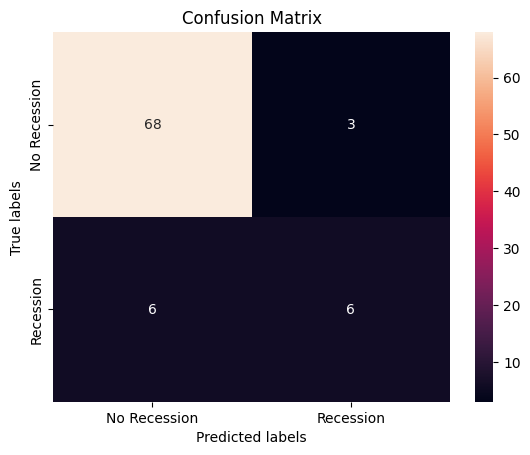

In [34]:
classifier= KNeighborsClassifier(n_neighbors = 2, metric='minkowski', p=2 )  
classifier.fit(X_train, y_train) 
y_pred = classifier.predict(X_test)


cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Recession', 'Recession']); ax.yaxis.set_ticklabels(['No Recession', 'Recession']);


prec = precision_score(y_test, y_pred)
print('Precision: ' +  str(prec))
rec = recall_score(y_test, y_pred)
print('Recall: ' + str(rec))
acc = accuracy_score(y_test, y_pred)
print('Accuracy:' + str(acc))

### Linear Regression

X shape: (274, 3)
y shape: (274, 1)
y_pred shape: (83,)


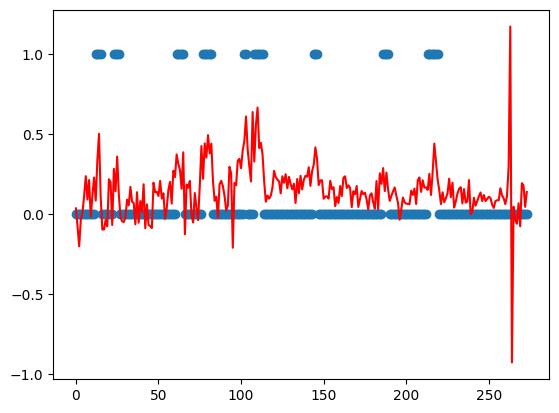

In [35]:
X = data[['int-rate','une-rate','r-gdp']]
y = data[['rec']]

linear_regressor = LinearRegression()
linear_regressor.fit(X, y)
Y_pred = linear_regressor.predict(X)

print('X shape: ' +  str(X.shape))
print('y shape: ' +  str(y.shape))
print('y_pred shape: ' +  str(y_pred.shape))

X = np.arange(0,len(X),1)

plt.scatter(X, y)
plt.plot(X, Y_pred, color='red')
plt.show()

# Nueral Network

In [36]:
X = data[['fed-rate','int-rate','une-rate','r-gdp']]
y = data[['rec']]

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.7, random_state=1 )
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,train_size = 0.7, random_state=1 )

# st_x= StandardScaler()    
# X_train = st_x.fit_transform(X_train)    
# X_test = st_x.transform(X_test)
# X_val = st_x.transform(X_val) 

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)    
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

print('X_train shape: ' +  str(X_train.shape))
print('y_train shape: ' +  str(y_train.shape))
print('X_val shape: ' +  str(X_val.shape))
print('y_val shape: ' +  str(y_val.shape))
print('X_test shape: ' +  str(X_test.shape))
print('y_test shape: ' +  str(y_test.shape))

from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense
histories = []

model = Sequential()
model.add(Dense(8, activation='relu', input_shape=(194,4)))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train,epochs = 50, batch_size = 10,validation_data = (X_val, y_val), verbose=1)

print(model.summary())

r_squared = model.evaluate(X_train, y_train)
print(r_squared)

histories.append(history)

X_train shape: (133, 4)
y_train shape: (133, 1)
X_val shape: (58, 4)
y_val shape: (58, 1)
X_test shape: (83, 4)
y_test shape: (83, 1)
2022-12-03 04:57:41.200130: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-03 04:57:41.510041: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-03 04:57:41.510069: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-03 04:57:41.592431: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting t

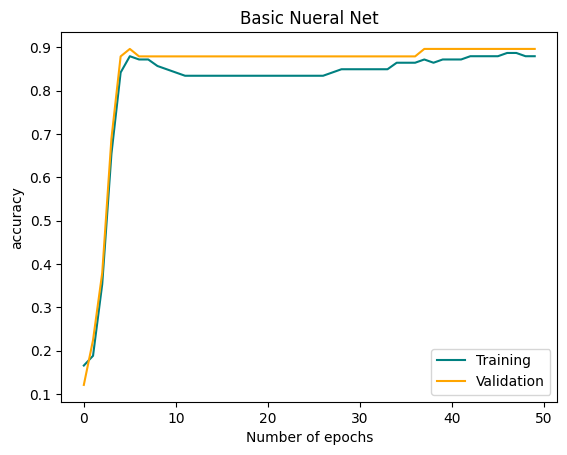

In [37]:
plt.plot(histories[0].history["accuracy"], color = "teal", label = "Training")
plt.plot(histories[0].history["val_accuracy"], color = "orange", label = "Validation")

plt.title("Basic Nueral Net")
plt.xlabel("Number of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
Precision: 0.5
Recall: 0.3333333333333333
Accuracy:0.8554216867469879


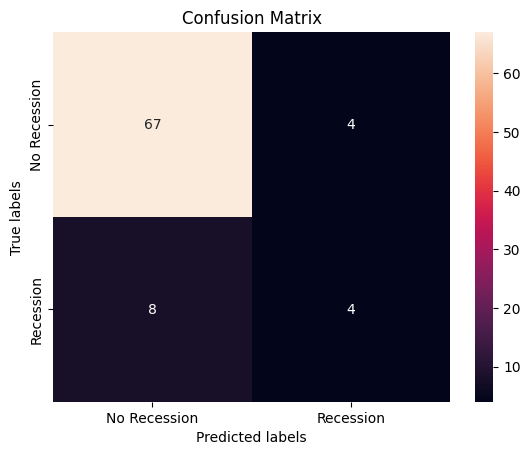

In [38]:
classifier= KNeighborsClassifier(n_neighbors = 2, metric='minkowski', p=2 )  
classifier.fit(X_train, y_train) 
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Recession', 'Recession']); ax.yaxis.set_ticklabels(['No Recession', 'Recession']);


prec = precision_score(y_test, y_pred)
print('Precision: ' +  str(prec))
rec = recall_score(y_test, y_pred)
print('Recall: ' + str(rec))
acc = accuracy_score(y_test, y_pred)
print('Accuracy:' + str(acc))

# Prediction with oversampling 

In [39]:
!pip install imblearn

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


### Regression

In [40]:
data = data.dropna()
X = data[['int-rate','une-rate','r-gdp']]
y = data[['rec']]
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('intercept: ' +  str(regr.intercept_))
print('coef: ' +  str(regr.coef_))
print('score: ' +  str(regr.score(X, y)))

#Add Oversampling
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.7, random_state=1 )

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)    
X_test = scaler.transform(X_test)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
model = sm.OLS(y_train, X_train).fit()

print(model.summary())

print('X_train shape: ' +  str(X_train.shape))
print('y_train shape: ' +  str(y_train.shape))
print('X_test shape: ' +  str(X_test.shape))
print('y_test shape: ' +  str(y_test.shape))


intercept: [0.10234818]
coef: [[ 0.01951122  0.00944141 -0.03155952]]
score: 0.20490006389166027
                            OLS Regression Results                            
Dep. Variable:                    rec   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     51.09
Date:                Sat, 03 Dec 2022   Prob (F-statistic):           4.90e-27
Time:                        04:58:04   Log-Likelihood:                -172.92
No. Observations:                 326   AIC:                             353.8
Df Residuals:                     322   BIC:                             369.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
Precision: 0.9130434782608695
Recall: 0.8289473684210527
Accuracy:0.8642857142857143


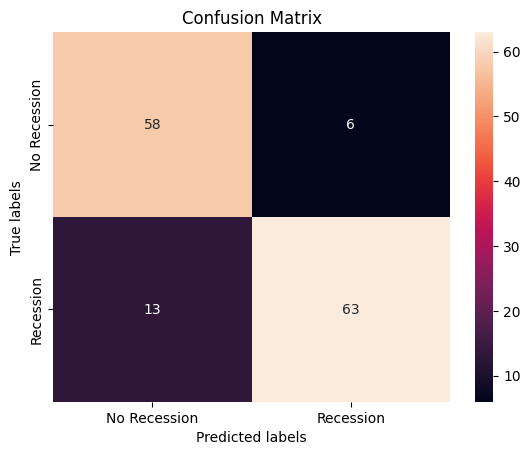

In [41]:
classifier= KNeighborsClassifier(n_neighbors = 2, metric='minkowski', p=2 )  
classifier.fit(X_train, y_train) 
y_pred = classifier.predict(X_test)


cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Recession', 'Recession']); ax.yaxis.set_ticklabels(['No Recession', 'Recession']);


prec = precision_score(y_test, y_pred)
print('Precision: ' +  str(prec))
rec = recall_score(y_test, y_pred)
print('Recall: ' + str(rec))
acc = accuracy_score(y_test, y_pred)
print('Accuracy:' + str(acc))

### Neural Network

In [42]:
X = data[['fed-rate','int-rate','une-rate','r-gdp']]
y = data[['rec']]

#Add Oversampling
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.7, random_state=1 )
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,train_size = 0.7, random_state=1 )

# st_x= StandardScaler()    
# X_train = st_x.fit_transform(X_train)    
# X_test = st_x.transform(X_test)
# X_val = st_x.transform(X_val) 

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)    
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

print('X_train shape: ' +  str(X_train.shape))
print('y_train shape: ' +  str(y_train.shape))
print('X_val shape: ' +  str(X_val.shape))
print('y_val shape: ' +  str(y_val.shape))
print('X_test shape: ' +  str(X_test.shape))
print('y_test shape: ' +  str(y_test.shape))


histories = []

model = Sequential()
model.add(Dense(8, activation='relu', input_shape=(228,4)))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train,epochs = 50, batch_size = 10,validation_data = (X_val, y_val), verbose=1)

print(model.summary())

r_squared = model.evaluate(X_train, y_train)
print(r_squared)

histories.append(history)

X_train shape: (228, 4)
y_train shape: (228, 1)
X_val shape: (98, 4)
y_val shape: (98, 1)
X_test shape: (140, 4)
y_test shape: (140, 1)
Epoch 1/50
23/23 [==============================] - 1s 19ms/step - loss: 0.6982 - accuracy: 0.4912 - val_loss: 0.7059 - val_accuracy: 0.4592
Epoch 2/50
23/23 [==============================] - 0s 6ms/step - loss: 0.6928 - accuracy: 0.4912 - val_loss: 0.7024 - val_accuracy: 0.4592
Epoch 3/50
23/23 [==============================] - 0s 8ms/step - loss: 0.6879 - accuracy: 0.4956 - val_loss: 0.6985 - val_accuracy: 0.4592
Epoch 4/50
23/23 [==============================] - 0s 6ms/step - loss: 0.6842 - accuracy: 0.4956 - val_loss: 0.6952 - val_accuracy: 0.4592
Epoch 5/50
23/23 [==============================] - 0s 5ms/step - loss: 0.6802 - accuracy: 0.5263 - val_loss: 0.6931 - val_accuracy: 0.4898
Epoch 6/50
23/23 [==============================] - 0s 8ms/step - loss: 0.6767 - accuracy: 0.5395 - val_loss: 0.6926 - val_accuracy: 0.4898
Epoch 7/50
23/23 [=====

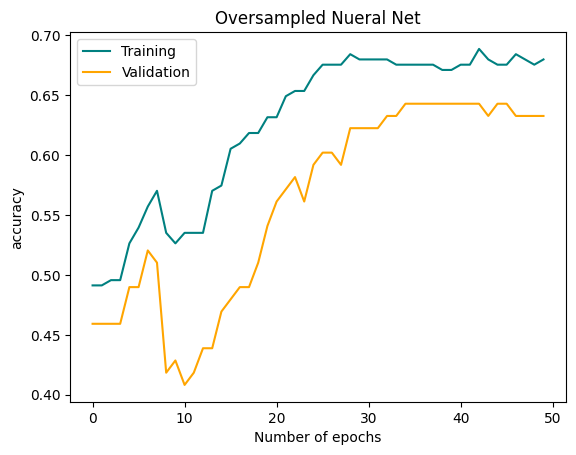

In [43]:
plt.plot(histories[0].history["accuracy"], color = "teal", label = "Training")
plt.plot(histories[0].history["val_accuracy"], color = "orange", label = "Validation")

plt.title("Oversampled Nueral Net")
plt.xlabel("Number of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
Precision: 0.9384615384615385
Recall: 0.8026315789473685
Accuracy:0.8642857142857143


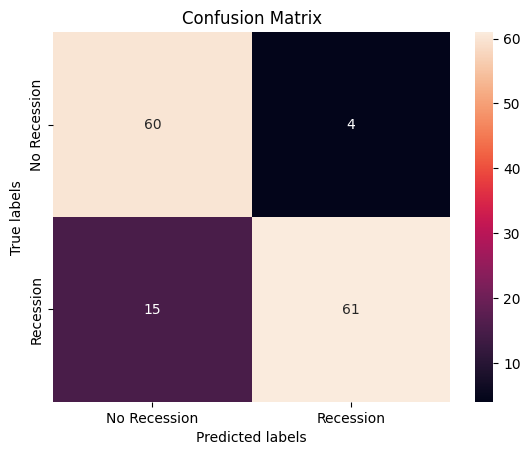

In [44]:
classifier= KNeighborsClassifier(n_neighbors = 2, metric='minkowski', p=2 )  
classifier.fit(X_train, y_train) 
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Recession', 'Recession']); ax.yaxis.set_ticklabels(['No Recession', 'Recession']);

prec = precision_score(y_test, y_pred)
print('Precision: ' +  str(prec))
rec = recall_score(y_test, y_pred)
print('Recall: ' + str(rec))
acc = accuracy_score(y_test, y_pred)
print('Accuracy:' + str(acc))
#Standard Scaler - Precision: 0.8470588235294118
#Standard Scaler - Recall: 0.9473684210526315
#Standard Scaler - Accuracy:0.8785714285714286

# Prediction with Undersampling

### Regression

In [45]:
data = data.dropna()
X = data[['int-rate','une-rate','r-gdp']]
y = data[['rec']]
regr = linear_model.LinearRegression()
regr.fit(X, y)

print('intercept: ' +  str(regr.intercept_))
print('coef: ' +  str(regr.coef_))
print('score: ' +  str(regr.score(X, y)))

#Add undersampling
nm1 = NearMiss(version=1)
X,y = nm1.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.7, random_state=1 )

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)    
X_test = scaler.transform(X_test)

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
model = sm.OLS(y_train, X_train).fit()

print(model.summary())

print('X_train shape: ' +  str(X_train.shape))
print('y_train shape: ' +  str(y_train.shape))
print('X_test shape: ' +  str(X_test.shape))
print('y_test shape: ' +  str(y_test.shape))


intercept: [0.10234818]
coef: [[ 0.01951122  0.00944141 -0.03155952]]
score: 0.20490006389166027
                            OLS Regression Results                            
Dep. Variable:                    rec   R-squared:                       0.467
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     15.48
Date:                Sat, 03 Dec 2022   Prob (F-statistic):           2.35e-07
Time:                        04:58:16   Log-Likelihood:                -23.354
No. Observations:                  57   AIC:                             54.71
Df Residuals:                      53   BIC:                             62.88
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
Precision: 1.0
Recall: 0.6428571428571429
Accuracy:0.8


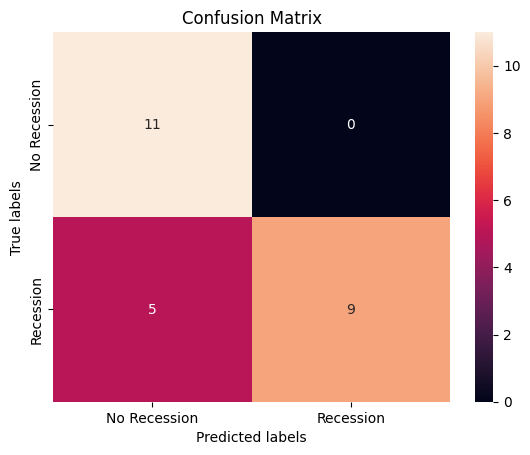

In [46]:
classifier= KNeighborsClassifier(n_neighbors = 2, metric='minkowski', p=2 )  
classifier.fit(X_train, y_train) 
y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Recession', 'Recession']); ax.yaxis.set_ticklabels(['No Recession', 'Recession']);

prec = precision_score(y_test, y_pred)
print('Precision: ' +  str(prec))
rec = recall_score(y_test, y_pred)
print('Recall: ' + str(rec))
acc = accuracy_score(y_test, y_pred)
print('Accuracy:' + str(acc))

### Nueral Network

In [47]:
X = data[['fed-rate','int-rate','une-rate','r-gdp']]
y = data[['rec']]

#Add Undersampling
nm1 = NearMiss(version=1)
X,y = nm1.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.7, random_state=1 )
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,train_size = 0.7, random_state=1 )

# st_x= StandardScaler()    
# X_train = st_x.fit_transform(X_train)    
# X_test = st_x.transform(X_test)
# X_val = st_x.transform(X_val) 

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)    
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

print('X_train shape: ' +  str(X_train.shape))
print('y_train shape: ' +  str(y_train.shape))
print('X_val shape: ' +  str(X_val.shape))
print('y_val shape: ' +  str(y_val.shape))
print('X_test shape: ' +  str(X_test.shape))
print('y_test shape: ' +  str(y_test.shape))


histories = []

model = Sequential()
model.add(Dense(8, activation='relu', input_shape=(39,4)))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train,epochs = 50, batch_size = 5,validation_data = (X_val, y_val), verbose=1)

print(model.summary())

r_squared = model.evaluate(X_train, y_train)
print(r_squared)

histories.append(history)

X_train shape: (39, 4)
y_train shape: (39, 1)
X_val shape: (18, 4)
y_val shape: (18, 1)
X_test shape: (25, 4)
y_test shape: (25, 1)
Epoch 1/50
8/8 [==============================] - 1s 69ms/step - loss: 0.6969 - accuracy: 0.3590 - val_loss: 0.6925 - val_accuracy: 0.5556
Epoch 2/50
8/8 [==============================] - 0s 13ms/step - loss: 0.6960 - accuracy: 0.4615 - val_loss: 0.6933 - val_accuracy: 0.4444
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.6943 - accuracy: 0.4359 - val_loss: 0.6934 - val_accuracy: 0.4444
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 0.6935 - accuracy: 0.4615 - val_loss: 0.6939 - val_accuracy: 0.3333
Epoch 5/50
8/8 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.4615 - val_loss: 0.6946 - val_accuracy: 0.3333
Epoch 6/50
8/8 [==============================] - 0s 6ms/step - loss: 0.6917 - accuracy: 0.4359 - val_loss: 0.6947 - val_accuracy: 0.3333
Epoch 7/50
8/8 [====================

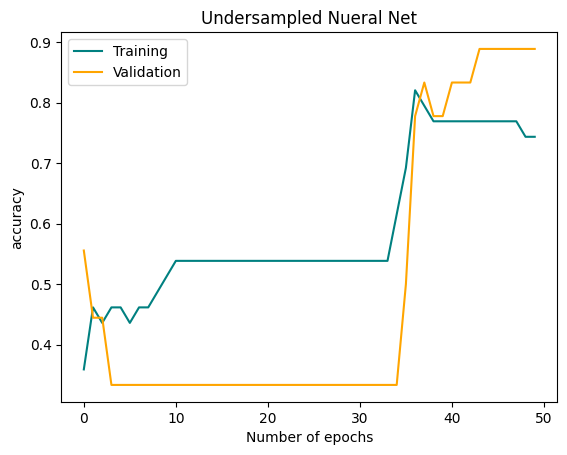

In [48]:
plt.plot(histories[0].history["accuracy"], color = "teal", label = "Training")
plt.plot(histories[0].history["val_accuracy"], color = "orange", label = "Validation")

plt.title("Undersampled Nueral Net")
plt.xlabel("Number of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
Precision: 0.9166666666666666
Recall: 0.7857142857142857
Accuracy:0.84


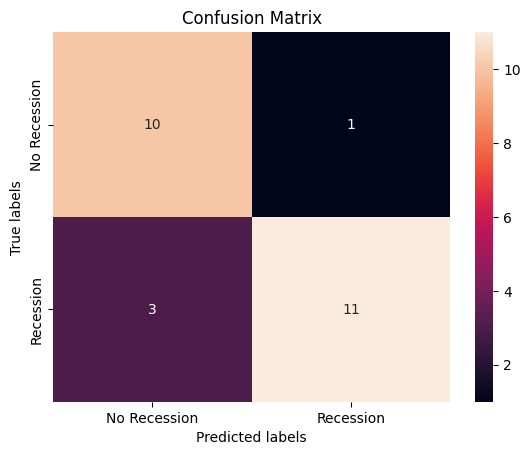

In [49]:
classifier= KNeighborsClassifier(n_neighbors = 5, metric='minkowski', p=2 )  
classifier.fit(X_train, y_train) 
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Recession', 'Recession']); ax.yaxis.set_ticklabels(['No Recession', 'Recession']);

prec = precision_score(y_test, y_pred)
print('Precision: ' +  str(prec))
rec = recall_score(y_test, y_pred)
print('Recall: ' + str(rec))
acc = accuracy_score(y_test, y_pred)
print('Accuracy:' + str(acc))
#Standard Scaler - Precision: 0.9166666666666666
#Standard Scaler - Recall: 0.7857142857142857
#Standard Scaler - Accuracy:0.84

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=027a3341-817b-41c9-a99b-70f75d6f2d5d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>